In [1]:
import torch
import tensorflow
from tensorflow.python.client import device_lib
def print_info():
    print('  Versión de TensorFlow: {}'.format(tensorflow.__version__))
    print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
    print('  Versión Cuda  -> {}'.format(tensorflow.sysconfig.get_build_info()['cuda_version']))
    print('  Versión Cudnn -> {}\n'.format(tensorflow.sysconfig.get_build_info()['cudnn_version']))

print_info()

  Versión de TensorFlow: 2.9.0
  GPU: ['device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5']
  Versión Cuda  -> 64_112
  Versión Cudnn -> 64_8



In [2]:
#Import from library
from datetime import date, time, datetime
import numpy as np
import cv2
from skimage.measure import label, regionprops, regionprops_table
from os import makedirs
#Importar librerias
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load saved models
from keras.models import load_model

In [3]:
## Creacion de Dataset
data_img=[]
for num in range(1,5201):
    num_img = str(num).rjust(5,'0')
    dir_img = 'Imagenes\data_all\{}.png'.format(num_img)
    temp_img= cv2.imread(dir_img, cv2.IMREAD_GRAYSCALE)
    #th, im_th = cv2.threshold(temp_img, 128, 255, cv2.THRESH_BINARY)
    #plt.imshow(temp_img)
    resize = cv2.resize(temp_img,(28,28),interpolation = cv2.INTER_CUBIC)
    data_img.append(resize)
data_img = np.asarray(data_img)
data_img = data_img / 255.0
data_img = data_img.reshape(5200,28,28,1)

(5200, 28, 28, 1)


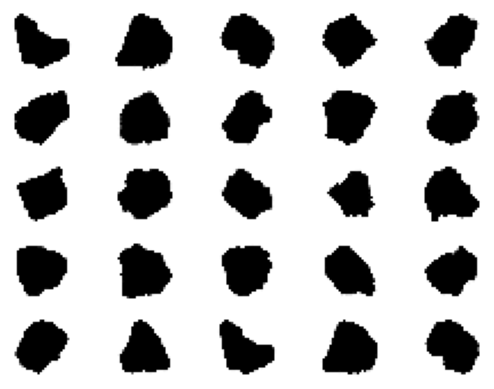

In [4]:
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data_img[i], cmap='gray_r')
#filename = 'base_plot_2DGAN{}.png'.format(str(date.today()))
#plt.savefig(filename)
#plt.close()
#summarize the shape of the dataset
print(data_img.shape)


In [5]:

# define the standalone dicriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same',
                     input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,
                    activation='sigmoid'))
    model.summary()
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:

#define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    #foundation for 7x7 image
    n_nodes =128 *7*7 #features maps*dimensions
    model.add(Dense(n_nodes,
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,
                     (7,7),
                     activation='sigmoid',
                     padding='same'))
    model.summary()
    return model


In [7]:

#define the combined generator and dicriminatro model,
#for updating the generator
def define_gan(g_model,d_model):
    #make weights in the discriminator not trainable
    d_model.trainable = False
    #connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    #add the discriminator
    model.add(d_model)
    model.summary()
    #compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [8]:

## load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = data_img
    #(trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    #X = (X-127.5) / 127.5
    return X


In [9]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y


In [10]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [11]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create ✬fake✬ class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [12]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n,n, 1+i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0],
                   cmap='gray_r')
     # save plot to file
    filename = 'results/2GAN/generated_2GAN_plot_e%04d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()


In [19]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
   
    x_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples)
   
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'generator_2D_model_%03d.h5' % (epoch + 1)
    #g_model.save(filename)



In [20]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a_hist):
    # plot loss
    #plt.subplot(2, 1, 1)
    plt.plot(d_hist, label='dis')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    #plt.subplot(2, 1, 2)
    #plt.plot(a_hist, label='acc')
    #plt.legend()
    # save plot to file
    plt.savefig('results/2GAN/plot_line_plot_loss.png')
    plt.close()

In [23]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=100, n_batch=256):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    
    # prepare lists for storing stats each iteration
    d_hist, g_hist, a_hist = list(), list(), list()

# manually enumerate epochs
    for i in range(n_steps):
        # Train the discriminator 
        ## get randomly selected real samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        ## combine into one batch
        X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
        # update discriminator model weights
        d_loss, d_acc = d_model.train_on_batch(X, y)
            
        #Train the generator
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator✬s error
        g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)
           
        # summarize loss on this batch
        print('>%d, d=%.3f, g=%.3f, a=%d' % (i+1, d_loss, g_loss, int(100*d_acc)))
        # record history
        d_hist.append(d_loss)
        g_hist.append(g_loss)
        a_hist.append(d_acc)
        # evaluate the model performance every epoch
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
            #epoch, g_model, d_model, dataset, latent_dim,
    plot_history(d_hist, g_hist, a_hist)

In [22]:
#Make folder in dir
makedirs('results/2GAN', exist_ok=True)
# size of the latent space
latent_dim = 50
# create the discriminator
d_model = define_discriminator()
# create the
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = data_img
#dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=20)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

4/4 [==============================] - 0s 5ms/step
>155, d=0.704, g=0.722, a=49
4/4 [==============================] - 0s 6ms/step
>156, d=0.721, g=0.724, a=46
4/4 [==============================] - 0s 6ms/step
>157, d=0.713, g=0.712, a=48
4/4 [==============================] - 0s 4ms/step
>158, d=0.690, g=0.705, a=52
4/4 [==============================] - 0s 4ms/step
>159, d=0.696, g=0.726, a=51
4/4 [==============================] - 0s 5ms/step
>160, d=0.681, g=0.710, a=60
4/4 [==============================] - 0s 5ms/step
>161, d=0.697, g=0.708, a=50
4/4 [==============================] - 0s 4ms/step
>162, d=0.686, g=0.696, a=57
4/4 [==============================] - 0s 9ms/step
>163, d=0.699, g=0.667, a=50
4/4 [==============================] - 0s 4ms/step
>164, d=0.695, g=0.675, a=51
4/4 [==============================] - 0s 5ms/step
>165, d=0.706, g=0.678, a=49
4/4 [==============================] - 0s 5ms/step
>166, d=0.712, g=0.653, a=45
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step
>353, d=0.702, g=0.735, a=46
4/4 [==============================] - 0s 4ms/step
>354, d=0.693, g=0.733, a=50
4/4 [==============================] - 0s 8ms/step
>355, d=0.695, g=0.738, a=49
4/4 [==============================] - 0s 4ms/step
>356, d=0.701, g=0.727, a=45
4/4 [==============================] - 0s 4ms/step
>357, d=0.692, g=0.738, a=51
4/4 [==============================] - 0s 9ms/step
>358, d=0.695, g=0.731, a=52
4/4 [==============================] - 0s 9ms/step
>359, d=0.684, g=0.721, a=57
4/4 [==============================] - 0s 5ms/step
>360, d=0.694, g=0.727, a=52
4/4 [==============================] - 0s 7ms/step
>361, d=0.698, g=0.717, a=53
4/4 [==============================] - 0s 4ms/step
>362, d=0.700, g=0.723, a=46
4/4 [==============================] - 0s 9ms/step
>363, d=0.702, g=0.708, a=46
4/4 [==============================] - 0s 6ms/step
>364, d=0.713, g=0.687, a=41
4/4 [==============================] - 0

In [ ]:
plt.imshow(dataset[0,:,:,0])

# Generacion de Modelos

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot_predict(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

In [ ]:
# load model
model = load_model('generator_2D_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot_predict(X, 5)